# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Finding Project 

#### By:- Subhendu Mishra (http://github.com/mishrsu)

## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
import math
#from cv2 import cv
import glob
import PyQt5
import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import matplotlib.image as mpimg
%matplotlib inline

## Compute Camera Caliberation Matrix and Distortion Coefficients

In [2]:

nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
    
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
#ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)


## Apply Distortion Correction to Raw Images

In [3]:
def cal_undistort(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1],gray.shape[0])
    ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size[:2],None,None)
    undist = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    return undist

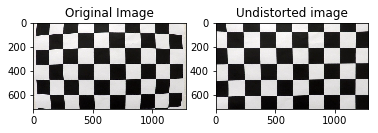

In [4]:
img = mpimage.imread('camera_cal/calibration1.jpg')
out = cal_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Undistorted image')
ax2.imshow(out)

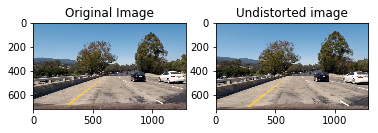

In [5]:
img = mpimage.imread('test_images/test1.jpg')
out = cal_undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Undistorted image')
ax2.imshow(out)

## Use Color Transforms Gradient etc. to create threshold binary image

In [6]:
#Obtaining combined color/gradient threshold binary image
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh_x(img, thresh_min=20, thresh_max=100):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ###########
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)

    #Convert the absolute value image to 8-bit:

    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    ##########
    
    # Return the result
    return sxbinary

def abs_sobel_thresh_y(img, thresh_min=20, thresh_max=100):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ###########
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobely = np.absolute(sobely)

    #Convert the absolute value image to 8-bit:

    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sybinary, cmap='gray')
    ##########
    
    # Return the result
    return sybinary

def color_grad(image, color_thresh = (0,255)):
    '''Returns binary output for saturation color threshold'''
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls_image[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > color_thresh[0]) & (s_channel <= color_thresh[1])] = 1
    return s_binary
     
def dir_thresh(image, sobel_kernel=3, thresh=(0,np.pi/2)):
    '''Returns binary output for direction of gradient of undistorted image'''
    gray_test = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray_test, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_test, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_gradient = np.arctan2(np.absolute(sobel_x), np.absolute(sobel_y))
    
    binary_output_dir = np.zeros_like(abs_gradient)
    #binary_output_dir[(abs_gradient >= 1) & (abs_gradient <= 1.6)] = 1
    binary_output_dir[(abs_gradient >= thresh[0]) & (abs_gradient <= thresh[1])] = 1

    return binary_output_dir

def abs_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def combined_binary_output(image,dir_kernel = 15, mag_kernel =15, thresh=(0.7,1.4), mag_thresh=(17,80),color_thresh = (0,255)):
    '''Takes binary thresholds and combines them into one image'''
    dir_binary = dir_thresh(image, sobel_kernel=dir_kernel, thresh= thresh)
    abs_binary = abs_mag_thresh(image, sobel_kernel=mag_kernel, mag_thresh=mag_thresh)
    color_binary = color_grad(image,color_thresh)
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(color_binary ==1)|((dir_binary == 1) & (abs_binary == 1))] = 1
     
    return combined_binary

def show_contribution(image,dir_kernel = 15, mag_kernel =15, thresh=(0.7,1.4), mag_thresh=(17,80),color_thresh = (0,255)):
    '''Shows contribution of gradient thresholds and color thresholds'''
    dir_binary = dir_thresh(image, sobel_kernel=dir_kernel, thresh= thresh)
    abs_binary = abs_mag_thresh(image, sobel_kernel=mag_kernel, mag_thresh=mag_thresh)

    grad_binary = np.zeros_like(dir_binary)
    grad_binary[(dir_binary == 1) & (abs_binary == 1)] = 1
    
    color_binary = color_grad(image,color_thresh)
    
    contribution = np.dstack((np.zeros_like(dir_binary),grad_binary, color_binary))
    
    return contribution


In [7]:
def binary_image(image):
    thresh_min=20
    thresh_max=100
    sobel_kernel = 3
    thresh=(0.7, 1.3)
    gray_test = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    out1 = abs_sobel_thresh_x(image,thresh_min=20, thresh_max=100)    
    
    sobel_x = cv2.Sobel(gray_test, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_test, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_gradient = np.arctan2(np.absolute(sobel_x), np.absolute(sobel_y))
    
    binary_output_dir = np.zeros_like(abs_gradient)
    binary_output_dir[(abs_gradient >= 1) & (abs_gradient <= 1.6)] = 1
    
    dir_binary = dir_thresh(image, sobel_kernel=3, thresh=(1, 1.6))
    
    mag_binary = abs_mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    thresh = (90, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    thresh = (15, 100)
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
   

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh_x(image, thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh_y(image, thresh_min=20, thresh_max=100)
    mag_binary = abs_mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=(30, 100))
    dir_binary = dir_thresh(image, sobel_kernel=sobel_kernel, thresh=(1.3, 1.6))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    sxbinary = color_grad(image, color_thresh = (90, 255))
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, combined))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(combined == 1) | (sxbinary == 1)] = 1
    return combined_binary

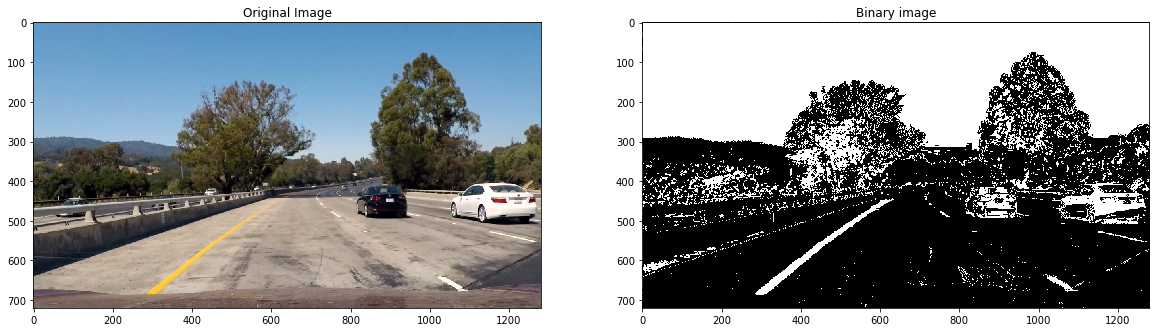

In [8]:

img = mpimage.imread('test_images/test1.jpg')
out = binary_image(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Binary image')
ax2.imshow(out, cmap ='gray')



## Apply a perspective transform to rectify binary image ("birds-eye view")

In [9]:
def corners_unwarp(binary_img):

    image_size = (binary_img.shape[1], binary_img.shape[0])
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(binary_img, M, image_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [10]:
def corners_warp(binary_img, image_size):

    #image_size = (binary_img.shape[1], binary_img.shape[0])
    w,h = image_size[0], image_size[1]
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(binary_img, Minv, image_size, flags=cv2.INTER_LINEAR)
    
    return warped

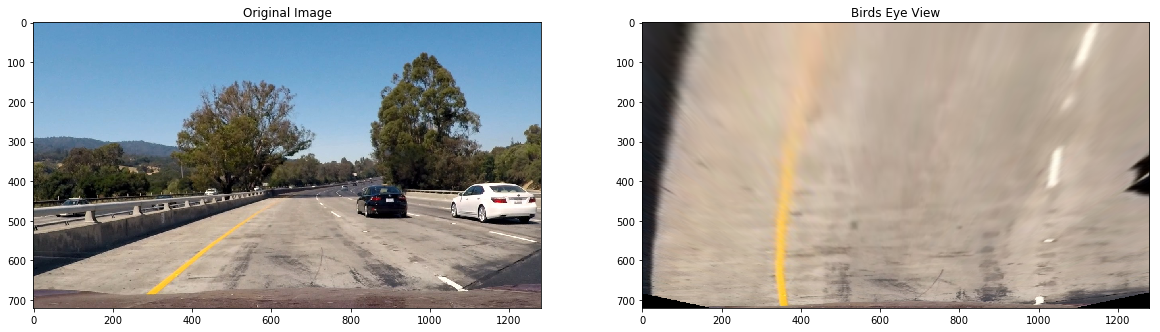

In [11]:
img = mpimage.imread('test_images/test1.jpg')
result = cal_undistort(img)
warped = corners_unwarp(result)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Birds Eye View')
ax2.imshow(warped)

## Detect lane pixels and fit to find the lane boundary.

In [12]:
def sliding_window(binary_warped):
 
        
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
  
    return out_img, ploty, left_fit, right_fit

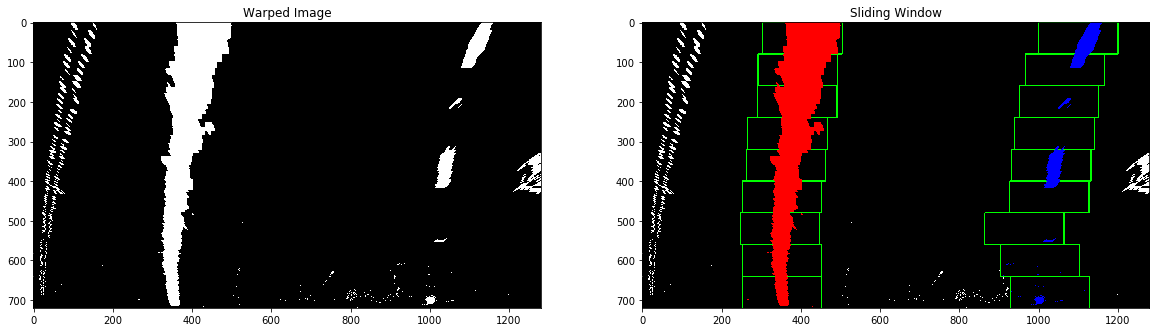

In [13]:

img = mpimage.imread('test_images/test1.jpg')
result = cal_undistort(img)
binary = binary_image(result)
binary_warped = corners_unwarp(binary)
out, ploty, leftx, rightx = sliding_window(binary_warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Warped Image')
ax1.imshow(binary_warped, cmap='gray')
ax2.set_title('Sliding Window')
ax2.imshow(out)

In [14]:
  def lane_lines(binary_warped, ploty, left_fit, right_fit):
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    leftx = left_fitx
    rightx = right_fitx
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return result, ploty, left_fitx, right_fitx

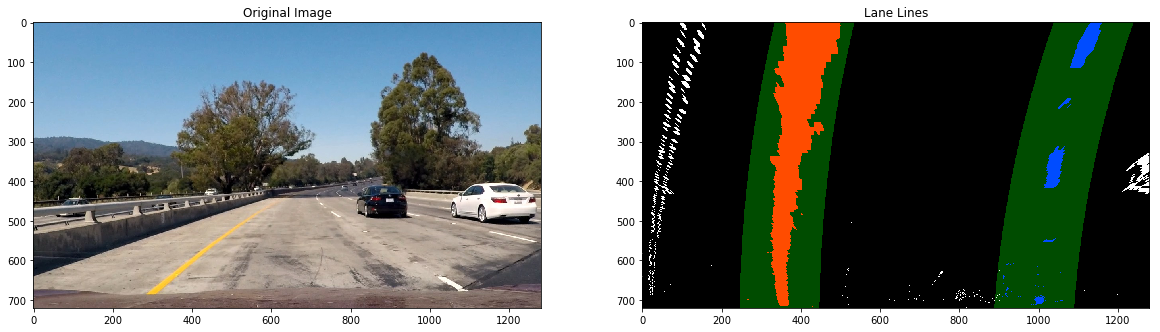

In [15]:

img = mpimage.imread('test_images/test1.jpg')
result = cal_undistort(img)
binary = binary_image(result)
binary_warped = corners_unwarp(binary)
out_img, ploty, leftx, rightx = sliding_window(binary_warped)
out, ploty, left_fitx, right_fitx = lane_lines(binary_warped, ploty,leftx, rightx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Lane Lines')
ax2.imshow(out)

##  Determine the curvature of the lane and vehicle position with respect to center.
.

In [16]:
def curvature(image, ploty, leftx, rightx ):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curve_radius = int(min(left_curverad , right_curverad))
    camera_position = image.shape[1]/2
    lane_center = (rightx[719] + leftx[719])/2
    vehicle_direction=' '
    if((camera_position - lane_center) > 0):
        vehicle_direction = 'right'
    else:
        vehicle_direction = 'left'
    center_offset_pixels = abs(camera_position - lane_center)
    vehicle_position = float("{0:.2f}".format((3.7 * center_offset_pixels)/1000))
    return curve_radius, vehicle_position, vehicle_direction

857
0.1
left


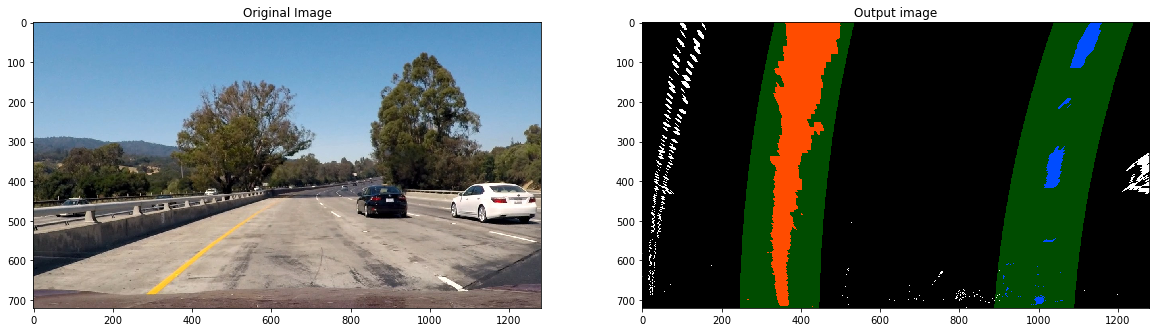

In [17]:

img = mpimage.imread('test_images/test1.jpg')
result = cal_undistort(img)
binary = binary_image(result)
binary_warped = corners_unwarp(binary)
out_img, ploty, leftx, rightx = sliding_window(binary_warped)
out, ploty, left_fitx, right_fitx = lane_lines(binary_warped, ploty,leftx, rightx)
radius, position, direction = curvature(result, ploty, left_fitx, right_fitx )
print(radius)
print(position)
print(direction)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Output image')
ax2.imshow(out)



##  Warp the detected lane boundaries back onto the original image
.

In [18]:
def process_image(image, binary, ploty, left_fitx, right_fitx):

  
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    image_size = (binary.shape[1], binary.shape[0])
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = corners_warp(color_warp, image_size) 
    # Combine the result with the original image
    process_result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
    
    return process_result

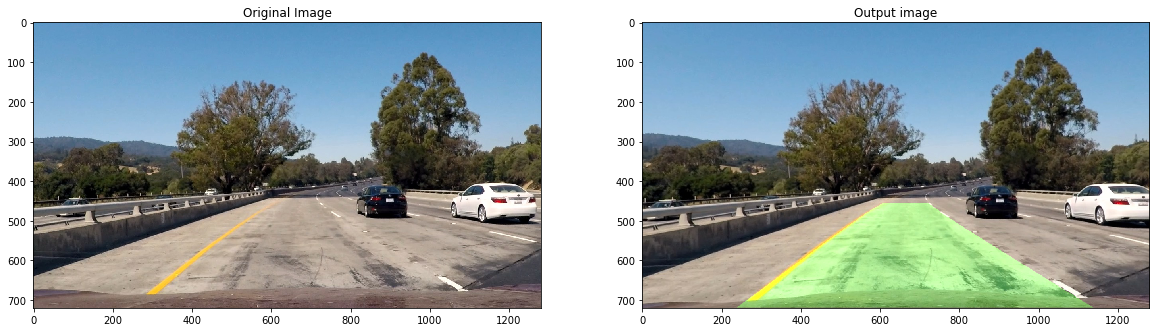

In [19]:

img = mpimage.imread('test_images/test1.jpg')
result = cal_undistort(img)
binary = binary_image(result)
binary_warped = corners_unwarp(binary)
out_img, ploty, leftx, rightx = sliding_window(binary_warped)
out, ploty, left_fitx, right_fitx = lane_lines(binary_warped, ploty,leftx, rightx)
radius, position, direction = curvature(result, ploty, left_fitx, right_fitx )
final = process_image(result, binary_warped, ploty, left_fitx, right_fitx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Output image')
ax2.imshow(final)



##  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
.

In [20]:
def pipeline(image):
    img = image
    result = cal_undistort(img)
    binary = binary_image(result)
    binary_warped = corners_unwarp(binary)
    out_img, ploty, leftx, rightx = sliding_window(binary_warped)
    out, ploty, left_fitx, right_fitx = lane_lines(binary_warped, ploty,leftx, rightx)
    radius, position, direction = curvature(result, ploty, left_fitx, right_fitx )
    final = process_image(result, binary_warped, ploty, left_fitx, right_fitx)
    vid = final
    curve = 'Radius of Curvature = '+ str(radius) + ' (m)'
    pos = 'Vehicle is '+ str(position) + ' (m) ' + direction + ' of Center'
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(vid,curve,(10,70), font, 1.5,(255,255,255),2)
    cv2.putText(vid,pos,(10,140), font, 1.5,(255,255,255),2)
    return vid

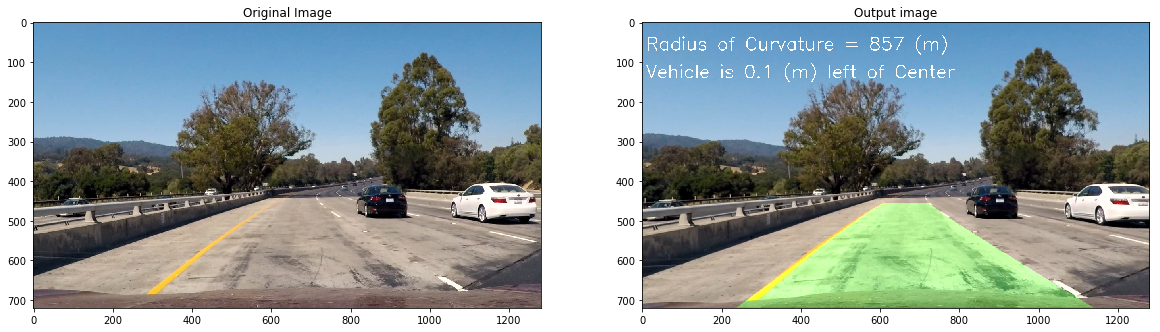

In [21]:
img = mpimage.imread('test_images/test1.jpg')
final = pipeline(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(img)
ax2.set_title('Output image')
ax2.imshow(final)

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project4.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project4.mp4
[MoviePy] Writing video project4.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:00:22<00:01,  1.67s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project4.mp4 

